# Homework 2 - Stochastic Block Model

Nicole Vadot

Due 19.12.2022

In [1]:
import numpy as np, numpy.typing as npt
from scipy.special import logsumexp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib as mpl, matplotlib.cm
from dataclasses import dataclass
from collections import defaultdict
import datetime
import itertools
from typing import Literal
import warnings
import pickle
from tqdm import tqdm
from multiprocessing import Pool

## Parameters & utilities

We define some BP parameters that uniquely determine a simulation.

In [2]:
@dataclass
class Params:
	c_in: float  # avg degree inside a class
	c_out: float  # avg degree between classes
	q: int  # number of classes
	N: int  # number of nodes
	damping: float = 0  # updated = (1-damping)*new + damping*current
	seed: int = 0  # random seed
	init: Literal['random', 'planted', 'paramagnetic'] = 'random'  # initialization mode

	@staticmethod
	def new_coloring_params(q: int, c: int, **kwargs) -> 'Params':
		"""Create a parameter set for graph coloring, i.e. `c_in = 0`

		Parameters
		----------
		q : int
			number of classes
		c : int
			average degree
		**kwargs :
			remaining arguments to ``Params`` constructor

		Returns
		-------
		Params
		"""
		return Params(c_in=0, c_out=c*q/(q-1), q=q, **kwargs)

In [3]:
# saving the entire BP class is expensive in memory, so we only save these
@dataclass
class BPSave:
	logchi: npt.NDArray[np.float64]
	logmu: npt.NDArray[np.float64]
	h: npt.NDArray[np.float64]
	t: int
	params: Params

In [4]:
def log_logA_dot_B(logA: npt.NDArray[np.float64], B: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
	"""Computes log(A@B), given log(A) and B
	
	Typically useful if A has large mean, but small fluctuations. This method prevent overflowing the exp
	"""
	maxlogA = logA.max()
	return maxlogA + np.log(np.exp(logA-maxlogA) @ B)

## BP iterator

We rewrite the BP equations, using log messages and defining $Y_{s_i}^{j \rightarrow i}$ (to optimize the computations) : 

$$
\begin{aligned}
Y_{s_i}^{j \rightarrow i} &= \sum_{s_j} C_{s_j,s_i} \chi_{s_j}^{j \rightarrow i}\\
\log \chi_{s_i}^i &= \underbrace{\log n_{s_i} - h_{s_i} + \sum_{j \in \partial i} \log Y^{j \rightarrow i}_{s_i}}_{\log \tilde \chi_{s_i}^i} - \log Z^i\\
\log \chi_{s_i}^{i \rightarrow j} &=\begin{cases}
	\log \chi_{s_i}^i + \mathcal{O}(\frac 1N) \quad& \text{if } (i,j)\notin E \\
	\log \tilde \chi_{s_i}^i - \log Y_{s_i}^{j \rightarrow i} - \log Z^{i \rightarrow j} \quad& \text{if } (i,j) \in E
\end{cases}\\
h_{s_i} &= \frac 1 N \sum_k \sum_{s_k} C_{s_k,s_i} \chi_{s_k}^k
\end{aligned}
$$

The normalization constants can be computed as $\log Z^i = \textrm{logsumexp}_{s_i} \log \tilde \chi_{s_i}^i$, and similarly for $\log Z^{i \rightarrow j}$.

We additionally add support for damped iterations to help convergence.

In [5]:
class BP:
	LOGEPS: float = 2e-40

	def __init__(self, params: Params):
		self.params = params

		# generate the class for each node
		# uniform sampling : n_a -> 1/q as N -> infty
		# NOTE : each node is uniquely identified by its index in the node_to_class array
		# i.e. i = 0 .. N-1
		rng = np.random.default_rng(self.params.seed)
		self.node_to_class: npt.NDArray[np.int64] = rng.integers(0, self.params.q, self.params.N)
		self.s_star = self.node_to_class  # alias

		# precompute 1hot encoding of the node classes
		self.nodes_1hot = np.zeros((self.params.N, self.params.q), dtype=np.int8)  # NOTE : in numpy, bools are stored on 8 bits (1 byte)
		self.nodes_1hot[range(self.params.N), self.node_to_class] = 1

		# precompute mappings from class to its nodes, and the number of nodes
		self.class_to_nodes = { a: np.nonzero(self.nodes_1hot[:, a])[0] for a in range(self.nodes_1hot.shape[1]) }
		self.class_to_numnodes = { a: len(nodes) for a, nodes in self.class_to_nodes.items() }

		# precompute c_ab matrix
		self.c_ab: npt.NDArray[np.float64] = np.full((self.params.q, self.params.q), self.params.c_out, dtype=float)
		self.c_ab[np.diag_indices_from(self.c_ab)] = self.params.c_in

		# precompute n vector
		self.n: npt.NDArray[np.float64] = np.array([ self.class_to_numnodes[a]/self.params.N for a in range(self.params.q) ], dtype=float)
		self.logn: npt.NDArray[np.float64] = np.log(self.n)

		# precompute average degree
		self.c: float = np.einsum('ab,a,b', self.c_ab, self.n, self.n)

		# generate the edges
		# NOTE : it is possible for the graph to have isolated nodes, which are ignored during BP
		rng = np.random.default_rng(self.params.seed)
		edges = []
		for a, b in itertools.combinations_with_replacement(range(4), 2):
			s = (self.class_to_numnodes[a], self.class_to_numnodes[b])  # shape of the random matrices
			if a == b:
				edges_in_class = np.nonzero(np.triu(rng.random(s) < self.params.c_in / self.params.N, 1))
			else:
				edges_in_class = np.nonzero(rng.random(s) < self.params.c_out / self.params.N)
			edges.append(np.vstack((self.class_to_nodes[a][edges_in_class[0]], self.class_to_nodes[b][edges_in_class[1]])))
		edges = np.hstack(edges).T  # raw generated edges
		self.ord_edges: npt.NDArray[np.int64] = np.unique(np.sort(edges, axis=1), axis=0)  # ordered edges (i, j), where i <= j, with no duplicates
		if len(self.ord_edges) == 0:
			raise RuntimeError(f'zero ordered edges have been generated, {edges}')
		self.full_edges: npt.NDArray[np.int64] = np.vstack((self.ord_edges, self.ord_edges[:, [1,0]]))  # all edges, in both directions : (i, j) and (j, i) are included
		self.E = len(self.ord_edges)
		# ord_edges = [
		#   (i1 -> j1)
		#   (i2 -> j2)
		#   ...
		#   (iE -> jE)
		# ]
		# full_edges = [
		#   (i1 -> j1)  ordered edges
		#   (i2 -> j2)  |
		#   ...         |
		#   (iE -> jE)  |
		#   (j1 -> i1)  flipped ordered edges
		#   (j2 -> i2)  |
		#   ...         |
		#   (jE -> iE)  |
		# ]

		# precompute neighbourhood of nodes
		# i -> neighbours of i
		self.neigh_node: dict[int, npt.NDArray[np.int64]] = { node: self.full_edges[self.full_edges[:, 0] == node][:, 1] for node in range(self.params.N) }
		# ij -> index of ij in the edge array
		self.edge_index: dict[tuple[int, int], int] = { (i, j): e for e, (i, j) in enumerate(self.full_edges) }
		# i -> index of ji in the edge array, for each j neighbor of i
		self.neigh_incoming_edge_index: dict[int, npt.NDArray[np.int64]] = {
			i: np.array([ self.edge_index[(j, i)] for j in self.neigh_node[i] ], dtype=np.int64)
			for i in range(self.params.N) }

		self.init()

	def init(self):
		# initialize messages
		# chi = [
		#   chi(i1 -> j1)
		#   chi(i2 -> j2)
		#   ... all ordered edges
		#   chi(j1 -> i1)
		#   chi(j2 -> i2)
		#   ... all reverse ordered edges
		# ]
		# -> (2E, q) matrix

		# initialize marginals
		# mu = [
		#   mu(1)
		#   mu(2)
		#   ... all nodes (even those not participating in graph, as they contribute to the h term !)
		#   mu(N-1)
		#   mu(N)
		# ]
		# -> (N, q) matrix

		if self.params.init == 'planted':
			chi = np.zeros((2*self.E, self.params.q), dtype=float)
			for e in range(len(chi)):
				i = self.full_edges[e, 0]  # extract i from directed edge (i, j)
				chi[e, :] = self.nodes_1hot[i]  # χi→j = vec δ(s*ᵢ, sᵢ)
			mu = np.zeros((self.params.N, self.params.q), dtype=float)
			for i in range(len(mu)):
				mu[i, :] = self.nodes_1hot[i]

		elif self.params.init == 'paramagnetic':
			chi = np.zeros((2*self.E, self.params.q), dtype=float)
			for e in range(len(chi)):
				i = self.full_edges[e, 0]  # extract i from directed edge (i, j)
				chi[e, :] = self.n  # χi→j = n
			mu = np.zeros((self.params.N, self.params.q), dtype=float)
			for i in range(len(mu)):
				mu[i, :] = self.n

		elif self.params.init == 'random':
			rng = np.random.default_rng(self.params.seed)
			chi = rng.random((2*self.E, self.params.q))
			mu = rng.random((self.params.N, self.params.q))

		else:
			raise RuntimeError(f'unknown initialization {self.params.init}')

		self.logchi: npt.NDArray[np.float64] = np.log(np.maximum(chi, BP.LOGEPS))  # take the log
		self.unnorm_logchi: npt.NDArray[np.float64] = self.logchi.copy()
		self.logchi -= logsumexp(self.logchi, axis=1)[:, None]  # normalize
		self.logmu: npt.NDArray[np.float64] = np.log(np.maximum(mu, BP.LOGEPS))  # take the log
		self.unnorm_logmu: npt.NDArray[np.float64] = self.logmu.copy()
		self.logmu -= logsumexp(self.logmu, axis=1)[:, None]  # normalize

		# initialize h
		# NOTE : h will get overwritten on the first iteration of BP, so we can init with whatever
		self.h = np.zeros(self.params.q)

		# initialize the delta
		# delta is not defined at the first iteration
		self.delta = np.nan

		# initialize time
		self.t = 0

	def __iter__(self):
		# comment out to reset on every run.
		# to be able to run where it left off from BPSave, leave commented out
		# self.init()
		return self

	def __next__(self):
		"""Performs one BP step"""
		# update h, numerically unstable way
		self.h = 1/self.params.N * np.einsum('ab,jb->a', self.c_ab, np.exp(self.logmu))
		# update h, numerically stable way
		# self.h = 1/self.params.N * np.exp(log_logA_dot_B(self.logmu, self.c_ab)).sum(axis=0)

		# NOTE : we use the current h for the computations of logmu and logchi
		logmu, logchi = self._message_step()
		self.unnorm_logmu = logmu.copy()  # take copies because we're modifying the arrays afterwards
		self.unnorm_logchi = logchi.copy()
		logmu -= logsumexp(logmu, axis=1)[:, None]  # normalized
		logchi -= logsumexp(logchi, axis=1)[:, None]  # normalized

		# compute delta
		self.delta = np.abs(logmu - self.logmu).max() + np.abs(logchi - self.logchi).max()
		
		# assign new arrays
		if self.params.damping > 0:
			self.logmu = (1-self.params.damping)*logmu + self.params.damping*self.logmu
			self.logchi = (1-self.params.damping)*logchi + self.params.damping*self.logchi
			self.logmu -= logsumexp(self.logmu, axis=1)[:, None]  # renormalize after the damping
			self.logchi -= logsumexp(self.logchi, axis=1)[:, None]  # renormalize after the damping
		else:
			self.logmu = logmu
			self.logchi = logchi
		
		self.t += 1

	def _message_step(self) -> tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
		"""Returns unnormalized logmu and logchi"""
		# precompute the matrix of sums over spins
		# numerically unstable way
		# y_edge = np.einsum('ab,ea->eb', self.c_ab, np.exp(self.logchi))
		# logy_edge = np.log(np.maximum(y_edge, BP.LOGEPS))
		# numerically stable way
		logy_edge = log_logA_dot_B(self.logchi, self.c_ab)

		# compute mu messages
		logmu = np.zeros_like(self.logmu)
		logmu += (self.logn - self.h)[None, :]
		# NOTE : we need this for loop, because neigh_incoming_edge_index would create a ragged index array
		for i in range(len(logmu)):
			logmu[i] += logy_edge[self.neigh_incoming_edge_index[i]].sum(axis=0)

		# explicit mu version (~ 20% slower)
		# # print('mu')
		# logmu = np.zeros_like(self.logmu)
		# for i in range(len(logmu)):
		# 	logmu[i, :] = self.logn - self.h
		# 	# print(f'node {i}')
		# 	for e in self.neigh_incoming_edge_index[i]:
		# 		# print(f'\tterm {self.full_edges[e,0]}->{self.full_edges[e,1]}')
		# 		logmu[i, :] += logy_edge[e, :]
		# # print('--')

		# compute chi messages
		logchi = np.zeros_like(self.logchi)
		for e, (i, j) in enumerate(self.full_edges):
			logchi[e, :] = logmu[i, :] - logy_edge[self.edge_index[(j, i)], :]

		# explicit chi version, without reusing the mu (much slower !!)
		# print('chi')
		# logchi = np.zeros_like(self.logchi)
		# for e, (i, j) in enumerate(self.full_edges):
		# 	print(f'edge {i}->{j}')
		# 	logchi[e, :] = self.logn - self.h
		# 	for k in self.neigh_node[i]:
		# 		if k == j: continue
		# 		print(f'\tterm {k}->{i}')
		# 		logchi[e, :] += logy_edge[self.edge_index[(k, i)], :]
		# print('--')

		return logmu, logchi

	def phi_bethe(self) -> float:
		"""Computes Bethe free entropy"""
		log_Zi: npt.NDArray[np.float64] = logsumexp(self.unnorm_logmu, axis=1)  # has length N
		chi = np.exp(self.logchi)
		chi_ij, chi_ji = chi[:self.E], chi[self.E:]
		Zij = np.einsum('ab,ea,eb->e', self.c_ab, chi_ij, chi_ji)
		log_Zij: npt.NDArray[np.float64] = np.log(np.maximum(Zij, BP.LOGEPS))  # has length E
		return (log_Zi.sum() - log_Zij.sum())/self.params.N + self.c/2

	def overlap(self) -> tuple[npt.NDArray[np.int64], float]:
		"""Computed overlap metric Q. Returns the s hat of largest overlap, and the corresponding overlap"""
		# convert s_hat to 1-hot matrix with no permutations
		s_hat0 = np.argmax(self.logmu, axis=1)
		nodes_1hot_hat0 = np.zeros((self.params.N, self.params.q), dtype=np.int8)
		nodes_1hot_hat0[range(self.params.N), s_hat0] = 1

		def compute_Q(pi: tuple[int, ...]):
			tp = ((nodes_1hot_hat0[:, pi] == 1) & (self.nodes_1hot == 1)).sum()  # true positives
			return pi, (tp/self.params.N - 1/self.params.q) / (1 - 1/self.params.q)

		pi_opt, Q = max(( compute_Q(pi) for pi in itertools.permutations(range(self.params.q)) ), key=lambda x: x[1] )
		return nodes_1hot_hat0[:, pi_opt].nonzero()[1], Q

	def run(self, tolerance: float = 1e-5, max_iter: int = 100, accumulate: list[Literal['logmu', 'logchi', 'h', 'delta', 'phi_bethe', 'overlap']] = [], init=True) -> dict[str, list]:
		accs = defaultdict(list)
		it = iter(self)
		
		if init:
			self.init()

		def log():
			accs['t'].append(self.t)
			accs['delta'].append(self.delta)
			if 'logmu' in accumulate: accs['logmu'].append(self.logmu.copy())
			if 'logchi' in accumulate: accs['logchi'].append(self.logchi.copy())
			if 'delta' in accumulate: accs['delta'].append(self.delta)
			if 'phi_bethe' in accumulate: accs['phi_bethe'].append(self.phi_bethe())
			if 'overlap' in accumulate: accs['overlap'].append(self.overlap()[1])

		log()

		for n in range(max_iter):
			next(it)
			log()

			if self.delta < tolerance:
				break
		
		if n == max_iter-1:
			warnings.warn('Max iteration limit')

		return accs

	def __str__(self):
		edgerepr = np.array2string(self.ord_edges).replace("\n", "")
		r = f'BP at t={self.t} with'
		r += f'\n* {self.params}'
		r += f'\n* ordered edges={edgerepr} (E={self.E})'
		r += f'\n* n (paramagnetic fixed point)={self.n}'
		# r += f'\n* connected nodes={np.array2string(self.connected_nodes, threshold=6)} (N={self.N})'
		r += f'\n* s star         ={np.array2string(self.s_star, threshold=20)}'
		s_max_overlap, Q = self.overlap()
		r += f'\n* s max overlap  ={np.array2string(s_max_overlap, threshold=20)}'
		r += f'\n* overlap={Q:.3f}'
		r += f'\n* phi_bethe={self.phi_bethe():.3f}'
		r += '\n-'
		logchirepr = np.array2string(np.exp(self.logchi), precision=3)
		r += f'\n* chi=\n{logchirepr}'
		logmurepr = np.array2string(np.exp(self.logmu), precision=3)
		r += f'\n* mu=\n{logmurepr}'
		hrepr = np.array2string(self.h, precision=3)
		r += f'\n* h={hrepr}'
		return r

	@staticmethod
	def from_save(save: BPSave) -> 'BP':
		bp = BP(save.params)
		bp.logmu = save.logmu.copy()
		bp.logchi = save.logchi.copy()
		bp.h = save.h.copy()
		bp.t = save.t
		return bp

	def save(self) -> BPSave:
		return BPSave(
			logchi=self.logchi.copy(),
			logmu=self.logmu.copy(),
			h=self.h.copy(),
			t=self.t,
			params=self.params
		)

## Debugging

### Manual iteration tests

In [6]:
bp = BP(Params(c_in=0.8, c_out=0.1, q=4, N=10, seed=0, init='planted'))
print(bp)

BP at t=0 with
* Params(c_in=0.8, c_out=0.1, q=4, N=10, damping=0, seed=0, init='planted')
* ordered edges=[[1 2] [5 7] [5 8] [7 8]] (E=4)
* n (paramagnetic fixed point)=[0.4 0.2 0.2 0.2]
* s star         =[3 2 2 1 1 0 0 0 0 3]
* s max overlap  =[3 2 2 1 1 0 0 0 0 3]
* overlap=1.000
* phi_bethe=0.237
-
* chi=
[[2.e-40 2.e-40 1.e+00 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40]
 [2.e-40 2.e-40 1.e+00 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40]]
* mu=
[[2.e-40 2.e-40 2.e-40 1.e+00]
 [2.e-40 2.e-40 1.e+00 2.e-40]
 [2.e-40 2.e-40 1.e+00 2.e-40]
 [2.e-40 1.e+00 2.e-40 2.e-40]
 [2.e-40 1.e+00 2.e-40 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40]
 [2.e-40 2.e-40 2.e-40 1.e+00]]
* h=[0. 0. 0. 0.]


In [7]:
bp.init()
it = iter(bp)

In [8]:
next(it)
print(bp)

BP at t=1 with
* Params(c_in=0.8, c_out=0.1, q=4, N=10, damping=0, seed=0, init='planted')
* ordered edges=[[1 2] [5 7] [5 8] [7 8]] (E=4)
* n (paramagnetic fixed point)=[0.4 0.2 0.2 0.2]
* s star         =[3 2 2 1 1 0 0 0 0 3]
* s max overlap  =[0 2 2 0 0 0 0 0 0 0]
* overlap=0.467
* phi_bethe=-0.564
-
* chi=
[[0.367 0.211 0.211 0.211]
 [0.823 0.059 0.059 0.059]
 [0.823 0.059 0.059 0.059]
 [0.823 0.059 0.059 0.059]
 [0.367 0.211 0.211 0.211]
 [0.823 0.059 0.059 0.059]
 [0.823 0.059 0.059 0.059]
 [0.823 0.059 0.059 0.059]]
* mu=
[[0.367 0.211 0.211 0.211]
 [0.148 0.085 0.682 0.085]
 [0.148 0.085 0.682 0.085]
 [0.367 0.211 0.211 0.211]
 [0.367 0.211 0.211 0.211]
 [0.974 0.009 0.009 0.009]
 [0.367 0.211 0.211 0.211]
 [0.974 0.009 0.009 0.009]
 [0.974 0.009 0.009 0.009]
 [0.367 0.211 0.211 0.211]]
* h=[0.38 0.24 0.24 0.24]


### Simulation tests

In [9]:
bp = BP(Params.new_coloring_params(q=5, c=18, N=1000, init='planted', damping=0.4))
print(bp)

BP at t=0 with
* Params(c_in=0, c_out=22.5, q=5, N=1000, damping=0.4, seed=0, init='planted')
* ordered edges=[[  1   8] [  1  34] [  1 103] ... [981 985] [981 996] [992 998]] (E=5118)
* n (paramagnetic fixed point)=[0.195 0.18  0.205 0.209 0.211]
* s star         =[4 3 2 ... 2 1 4]
* s max overlap  =[4 3 2 ... 2 1 4]
* overlap=1.000
* phi_bethe=-6.942
-
* chi=
[[2.e-40 2.e-40 2.e-40 1.e+00 2.e-40]
 [2.e-40 2.e-40 2.e-40 1.e+00 2.e-40]
 [2.e-40 2.e-40 2.e-40 1.e+00 2.e-40]
 ...
 [2.e-40 2.e-40 1.e+00 2.e-40 2.e-40]
 [1.e+00 2.e-40 2.e-40 2.e-40 2.e-40]
 [2.e-40 1.e+00 2.e-40 2.e-40 2.e-40]]
* mu=
[[2.e-40 2.e-40 2.e-40 2.e-40 1.e+00]
 [2.e-40 2.e-40 2.e-40 1.e+00 2.e-40]
 [2.e-40 2.e-40 1.e+00 2.e-40 2.e-40]
 ...
 [2.e-40 2.e-40 1.e+00 2.e-40 2.e-40]
 [2.e-40 1.e+00 2.e-40 2.e-40 2.e-40]
 [2.e-40 2.e-40 2.e-40 2.e-40 1.e+00]]
* h=[0. 0. 0. 0. 0.]


In [10]:
res = bp.run(accumulate=['phi_bethe', 'overlap'])
print(bp)

BP at t=55 with
* Params(c_in=0, c_out=22.5, q=5, N=1000, damping=0.4, seed=0, init='planted')
* ordered edges=[[  1   8] [  1  34] [  1 103] ... [981 985] [981 996] [992 998]] (E=5118)
* n (paramagnetic fixed point)=[0.195 0.18  0.205 0.209 0.211]
* s star         =[4 3 2 ... 2 1 4]
* s max overlap  =[4 3 2 ... 2 4 4]
* overlap=0.739
* phi_bethe=7.198
-
* chi=
[[2.483e-10 1.997e-02 1.233e-06 9.800e-01 1.260e-21]
 [2.506e-10 1.997e-02 1.233e-06 9.800e-01 1.260e-21]
 [4.399e-12 1.963e-02 1.234e-06 9.804e-01 1.269e-17]
 ...
 [9.826e-15 5.358e-03 4.792e-01 5.106e-01 4.887e-03]
 [9.830e-01 1.697e-02 5.850e-08 4.086e-16 2.717e-12]
 [1.214e-05 6.810e-04 1.104e-11 4.151e-11 9.993e-01]]
* mu=
[[5.676e-03 1.173e-04 9.385e-03 9.984e-03 9.748e-01]
 [4.399e-12 1.963e-02 1.234e-06 9.804e-01 1.260e-21]
 [1.294e-04 1.102e-02 9.888e-01 2.410e-08 2.917e-09]
 ...
 [5.052e-15 6.151e-05 9.999e-01 4.297e-12 2.353e-10]
 [1.214e-05 6.737e-04 1.197e-13 4.151e-11 9.993e-01]
 [5.676e-03 1.173e-04 9.385e-03 9.98

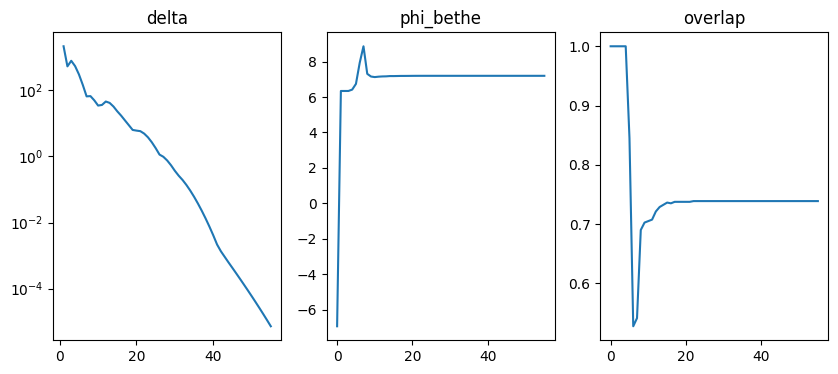

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 4))
ax[0].plot(res['t'], res['delta'])
ax[0].set_title('delta')
ax[0].set_yscale('log')
ax[1].plot(res['t'], res['phi_bethe'])
ax[1].set_title('phi_bethe')
ax[2].plot(res['t'], res['overlap'])
ax[2].set_title('overlap')
plt.show()

## Results

We run simulations with $q=5$ colors, $N=1024$ nodes. The damping factor is set to $0.3$.

The stability of the paramagnetic fixed point is at $c_{stab} = (q-1)^2$, in this case we have $c_{stab}=16$.

For each graph (i.e. each random seed), we run a simulation with the planted and the paramagnetic initialization ; and collect the results.

Each simulation runs as follows :
- initialization
- 80 BP iterations (at most, might be less if the update delta (defined as $\delta = \max_{\text{components}}(|\text{new message} - \text{old message}|)$) falls below the threshold $10^{-5}$)
- 20 BP iterations, where we also log the overlap $Q$ and the Bethe free entropy $\varphi_B$ at each iteration.

Since some simulations never properly converge but rather keep oscillating, we report the mean, max and last value of $Q$ and $\varphi_B$ of the final 20 BP iterations. Empirically it has been found that these different aggregations give very similar results.

In [12]:
q = 5
c_stab = (q-1)**2

### Do simulation stuff and save

#### CPU go brr

In [13]:
if False:  # re-run the computations (takes a long time ! ~ 10 mins on my machine)
	c_range = np.linspace(11, 18, 60)
	seeds = range(10)
	inits = ['planted', 'paramagnetic']
	checkpoints: list[BPSave] = []
	runs = []

	def do_run(params):
		c, seed, init = params  # slightly awkward to pass arguments into a process unpack
		bp = BP(Params.new_coloring_params(q=5, c=c, N=1024, init=init, seed=seed, damping=0.3))
		run = bp.run(max_iter=80)
		# run a few iterations more, while accumulating phi_bethe and overlap (expensive to compute),
		# so that we can average for simulations which oscillate without converging
		run_last = bp.run(max_iter=15, accumulate=['phi_bethe', 'overlap'], tolerance=0, init=False)
		return bp.save(), (c, seed, init, bp.c, run['t']+run_last['t'], run['delta']+run_last['delta'], run_last['phi_bethe'], run_last['overlap'])

	with warnings.catch_warnings():
		warnings.filterwarnings(action='ignore', message='Max iteration limit')
		with Pool() as pool:  # I paid for 12 CPU cores, so I'm gonna use 12 CPU cores >:)
			paramlist = list(itertools.product(c_range, seeds, inits))
			results = pool.imap_unordered(do_run, paramlist)

			for save, res in tqdm(results, total=len(paramlist)):
				checkpoints.append(save)
				runs.append(res)

	if True:  # save to disk
		with open(f'results {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}.pkl', 'wb') as file:
			pickle.dump(dict(runs=runs, checkpoints=checkpoints), file)


#### And I need to reopen

In [14]:
with open('results 2022-12-12 11:07:47.pkl', 'rb') as file:
	save = pickle.load(file)
runs = save['runs']
checkpoints: list[BPSave] = save['checkpoints']

#### Dataframe because pandas is cool :)

In [15]:
df = pd.DataFrame(runs, columns=['c', 'seed', 'init', 'c_exp', 't_run', 'delta_run', 'phi_bethe_run', 'overlap_run'])
df['phi_bethe_last'] = df.phi_bethe_run.map(lambda x: x[-1])
df['phi_bethe_mean'] = df.phi_bethe_run.map(lambda x: np.mean(x))
df['phi_bethe_max'] = df.phi_bethe_run.map(lambda x: np.max(x))
df['overlap_last'] = df.overlap_run.map(lambda x: x[-1])
df['overlap_mean'] = df.overlap_run.map(lambda x: np.mean(x))
df['overlap_max'] = df.overlap_run.map(lambda x: np.max(x))
df.sort_values(by=['c', 'seed', 'init'], inplace=True)
df.reset_index(drop=True, inplace=True)

#### Examine convergence

We inspect the converge of BP. Qualitatively, BP seems to converge well for $c \gtrsim c_{\text{stab}}$, and oscillates otherwise.

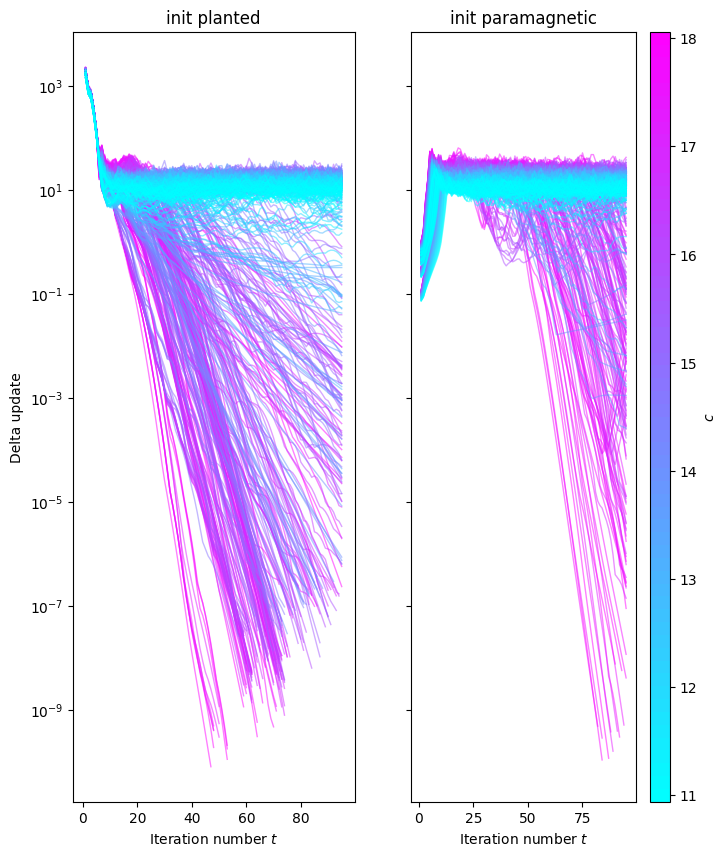

In [16]:
# examine convergence
fig, axs = plt.subplots(figsize=(8,10), ncols=2, sharey=True)
cmap = mpl.cm.get_cmap('cool')(np.linspace(0, 1, df['c'].nunique()))
ccolor = { c: color for c, color in zip(df['c'].unique(), cmap) }

for _, row in df.sort_values('c', ascending=False).query('init == "planted"').iterrows():
	axs[0].plot(row['t_run'], row['delta_run'], color=ccolor[row['c']], alpha=0.5, linewidth=1)
for _, row in df.sort_values('c', ascending=False).query('init == "paramagnetic"').iterrows():
	axs[1].plot(row['t_run'], row['delta_run'], color=ccolor[row['c']], alpha=0.5, linewidth=1)

cax, kw = mpl.colorbar.make_axes(axs[1], pad=0.05, aspect=40)
cb = mpl.colorbar.ColorbarBase(cax, cmap='cool', values=df['c'].unique(), label='$c$')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].set_xlabel('Iteration number $t$')
axs[1].set_xlabel('Iteration number $t$')
axs[0].set_ylabel('Delta update')
axs[0].set_title('init planted')
axs[1].set_title('init paramagnetic')
plt.show()

### Results : Overlap and Bethe free entropy curves

We plot the paramagnetic and planted curves, using markers :
- star marker (*) : value at last BP iteration
- cross marker (x) : mean value over last 20 BP iterations
- plus marker (+) : max value over last 20 BP iterations

The difference between the planted and paramagnetic free entropy is also plotted, to make it easier to see crossings.

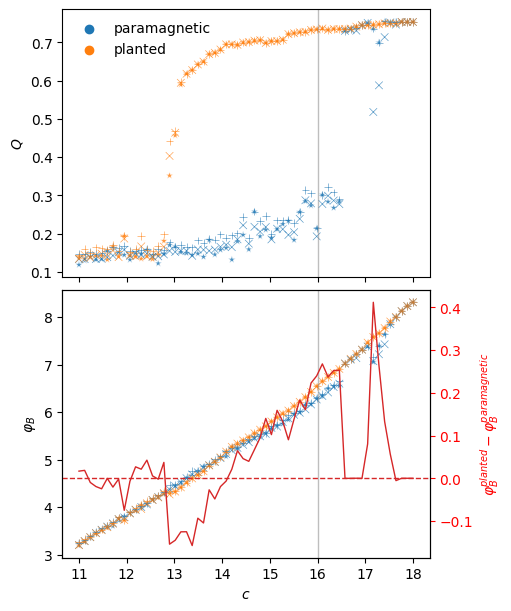

In [17]:
# uncomment to see all seeds, but I found seed=3 to give the best results
# for seed, df_seed in df.groupby('seed'):
for seed, df_seed in [(3, df.query('seed == 3'))]:
	# print(f'{seed=}')
	fig, axs = plt.subplots(figsize=(5, 6), nrows=2, sharex=True, constrained_layout=True)

	sns.scatterplot(df_seed, x='c', y='overlap_last', hue='init', ax=axs[0], s=30, alpha=0.8, marker='*')
	sns.scatterplot(df_seed, x='c', y='overlap_mean', hue='init', ax=axs[0], s=30, alpha=0.8, marker='x', legend=None)
	sns.scatterplot(df_seed, x='c', y='overlap_max', hue='init', ax=axs[0], s=30, alpha=0.8, marker='+', legend=None)

	with plt.rc_context({'ytick.color': 'red', 'axes.labelcolor': 'red'}):
		axdiff = axs[1].twinx()
		axdiff.plot(
			df_seed.query('init == "planted"').c,
			df_seed.query('init == "planted"').phi_bethe_max.values - df_seed.query('init == "paramagnetic"').phi_bethe_max.values,
			linewidth=1, color='tab:red'
		)
		axdiff.axhline(0, color='tab:red', linestyle='--', linewidth=1)
		axdiff.set_ylabel('$\\varphi_B^{planted} - \\varphi_B^{paramagnetic}$')

	sns.scatterplot(df_seed, x='c', y='phi_bethe_last', hue='init', ax=axs[1], s=30, alpha=0.8, marker='*', legend=None)
	sns.scatterplot(df_seed, x='c', y='phi_bethe_mean', hue='init', ax=axs[1], s=30, alpha=0.8, marker='x', legend=None)
	sns.scatterplot(df_seed, x='c', y='phi_bethe_max', hue='init', ax=axs[1], s=30, alpha=0.8, marker='+', legend=None)

	axs[0].axvline(c_stab, linestyle='-', alpha=0.5, linewidth=1, color='tab:gray')
	axs[1].axvline(c_stab, linestyle='-', alpha=0.5, linewidth=1, color='tab:gray')
	axs[0].set_xlabel('$c$')
	axs[0].set_ylabel('$Q$')
	axs[0].legend(loc='upper left', fancybox=False, framealpha=0, facecolor=None)
	axs[1].set_xlabel('$c$')
	axs[1].set_ylabel('$\\varphi_B$')

	plt.show()

Due to the numerical randomness of the graph there are some fluctuations, however we can still explain these results in terms of the theory.

```
0
|
| c < c_spinodal :
| planted and paramagnetic free entropies give the same results.
| overlap is around ~ 0.2 = 1/q (impossible phase).
|
|- c_spinodal ~ 12.8
|
| c_spinodal < c < c_first :
| planted free entropy drops below paramagnetic free entropy, and the planted overlap suddenly jumps to Q ~ 0.6.
| the paramagnetic initialization still hovers around Q ~ 0.2.
| in this regime, the paramagnetic initialization gives the "physically correct" results (impossible phase)
|
|- c_first ~ 14.1
|
| c_first < c < c_stab :
| now the planted initialization gives the largest free entropy.
| the problem is now solvable physically, but BP with paramagnetic initialization can't find the solution (hard phase)
|
|- c_stab = 16 (numerically for this graph seems to be around ~ 16.5)
|
| c_stab < c
| planted and paramagnetic again give the same free entropy and results.
|     (up to a numerical abnormality around c ~ 17.3, but the overall behavior is clear)
| the problem is can be solved by BP with paramagnetic initialization (easy phase)
|
v
c
```